# Domain Generation Algorithms (DGA) 

MITRE ATT&CK: https://attack.mitre.org/techniques/T1323/

## Preamble
In  order to facilitate command and control (C2) behaviours, Malware will reach out to an internet based host.  Historically, connection to this host was facilitated by a hardcoded domain name within the Malware.  This hardcoding meant that defenders were able to easily block access to this host by either reverse engineering a Malware sample or by examining network traffic and blackholing potential DNS requests.

Adversaries countered this tactic by the implementation of Domain Generation Algorithms (DGAs).  These algorithms would generate a number of domain names based on an initial seed or timestamp and attempt to reach out to those.  


## Detection Approaches

### NXDomains Counts
Given that a Malware sample may generate multiple domains and only an attacker need only register a single domain to facilitate a connection, one detection approach is to look at the number of NXDomain (Non-Existant Domain) responses that a host may typically make.

A naive approach to this problem is to setup a rule to alert on ANY NXDomain responses, however, this proves ineffective as a user may legitimately generate an NXDomain response by visiting a non-registered domain.  A more robust solution to this problem is explored here. 

### Feature Engineering
Lexigraphically, a Malware domain may contain higher levels of entrophy, vowel:constant ratios, etc.  Using ths, we may write a classifier to classifer whether a domain is within the class of dga or non-dga domains.

### Recurrent Neural Network
Scalable and easy to use technique for detection

## Datasets
* Cisco's Umbrella Popularity
 The popularity list contains our most queried domains based on passive DNS usage across our Umbrella global network of more than 100 Billion requests per day with 65 million unique active users, in more than 165 countries. Unlike Alexa, the metric is not based on only browser based 'http' requests from users but rather takes in to account the number of unique client IPs invoking this domain relative to the sum of all requests to all domains. In other words, our popularity ranking reflects the domain’s relative internet activity agnostic to the invocation protocols and applications where as ’site ranking’ models (such as Alexa) focus on the web activity over port 80 mainly from browsers. 
https://s3-us-west-1.amazonaws.com/umbrella-static/index.html


* DGA Sets from NetLab


## References
[1] - https://blog.malwarebytes.com/security-world/2016/12/explained-domain-generating-algorithm/

[2] - https://www.youtube.com/watch?v=jm7wH2G0h6c

<hr>

## NX Domain Detection


<hr>

## Recurrent Neural Networks (RNN)

In [1]:
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import sklearn
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Data Ingestion & Preprocessing

In [2]:
# Ingesting Benign Domains
benignDomains_df = pd.read_csv('dataset/CISCO-top-1m.csv', names=['domain'])
benignDomains_df['class'] = 0
benignDomains_df['src'] = 'cisco'

# Ingesting Malicious Domains
maliciousDomains_df = pd.read_csv('dataset/dga-domains.txt', sep='\t', usecols=[0,1], names=['src', 'domain'])
maliciousDomains_df['class'] = 1

# Merging Datasets
domains_df = pd.concat([maliciousDomains_df[0:10000], benignDomains_df[0:10000]], sort=False)
domains_df = domains_df.sample(frac=0.5)

domains_df.head()

,src,domain,class
2134,pykspa_v2_real,pycsrcegmyp.org,1
548,cisco,gspe1-ssl.ls.apple.com,0
8418,cisco,stats.avcdn.net,0
7748,cisco,dmca.com,0
8179,necurs,scfobyrhapwlayxpcuxp.bit,1


## Neural Network Preprocessing

### Generate Character Dictionary

In [3]:
def generate_char_dictionary(dataset):
    """Determines the set of characters within the data """
    
    chars_dict = dict() # Create an empty dict
    unique_chars = enumerate(set(''.join(dataset)))
    
    for i, x in unique_chars: 
        chars_dict[x] = i + 1
    
    return chars_dict

chars_dict = generate_char_dictionary(domains_df['domain'])
max_features = len(chars_dict) + 1
print(chars_dict)

{'x': 1, 'h': 2, 'y': 3, 'w': 4, '9': 5, '4': 6, '1': 7, '3': 8, 's': 9, 'a': 10, 'c': 11, '5': 12, '6': 13, 'n': 14, 'j': 15, '0': 16, 'q': 17, 'v': 18, 'f': 19, 'u': 20, 'd': 21, 'z': 22, '-': 23, 'm': 24, 'l': 25, 'b': 26, '7': 27, 'i': 28, 'e': 29, 'k': 30, '8': 31, '.': 32, 't': 33, 'r': 34, 'o': 35, 'g': 36, '2': 37, 'p': 38}


### Tokenize Training Data

In [4]:
def tokenizeString(domain, chars_dict):
    """Neural Networks require data to be tokenized as integers to work."""

    tokenList = []

    for char in domain:
        tokenList.append(chars_dict[char])
  
    return tokenList
    
    
def padToken(dataset, maxlen):

    newList = [0] * maxlen
    return newList + dataset

domains_df['tokenList'] = domains_df.apply(lambda row: tokenizeString(row['domain'], chars_dict), axis=1)
domains_df['tokenListLen'] = domains_df['tokenList'].apply(lambda x: len(x))

# Calculate the largest length within the DataFrame
maxlen = domains_df['tokenListLen'].max()

display(domains_df)


,src,domain,class,tokenList,tokenListLen
2134,pykspa_v2_real,pycsrcegmyp.org,1,"[38, 3, 11, 9, 34, 11, 29, 36, 24, 3, 38, 32, ...",15
548,cisco,gspe1-ssl.ls.apple.com,0,"[36, 9, 38, 29, 7, 23, 9, 9, 25, 32, 25, 9, 32...",22
8418,cisco,stats.avcdn.net,0,"[9, 33, 10, 33, 9, 32, 10, 18, 11, 21, 14, 32,...",15
7748,cisco,dmca.com,0,"[21, 24, 11, 10, 32, 11, 35, 24]",8
8179,necurs,scfobyrhapwlayxpcuxp.bit,1,"[9, 11, 19, 35, 26, 3, 34, 2, 10, 38, 4, 25, 1...",24
3374,qadars,3wpm7wxyj4de.com,1,"[8, 4, 38, 24, 27, 4, 1, 3, 15, 6, 21, 29, 32,...",16
5169,cisco,adserver.video,0,"[10, 21, 9, 29, 34, 18, 29, 34, 32, 18, 28, 21...",14
6178,cisco,forticlient.fortinet.net,0,"[19, 35, 34, 33, 28, 11, 25, 28, 29, 14, 33, 3...",24
5616,cisco,ws.sessioncam.com,0,"[4, 9, 32, 9, 29, 9, 9, 28, 35, 14, 11, 10, 24...",17
2215,pykspa_v2_real,hzkswrqqe.org,1,"[2, 22, 30, 9, 4, 34, 17, 17, 29, 32, 35, 34, 36]",13


In [5]:
def build_model(max_features_num, maxlen):
    """Build LSTM model"""
    model = Sequential()
    model.add(Embedding(max_features_num, 64, input_length=maxlen))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_crossentropy','acc'])

    return model

In [6]:
max_epoch=25
nfolds=10
batch_size=128

In [7]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss', 
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=5, #number of epochs with no improvement after which training will be stopped
                        verbose=0, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=False))

In [8]:
model = build_model(max_features, maxlen)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 73, 64)            2496      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 35,585
Trainable params: 35,585
Non-trainable params: 0
_________________

In [9]:
test = domains_df['tokenList'].values.tolist()


tokenList = sequence.pad_sequences(test, maxlen)

print(tokenList)
new_X = domains_df['tokenList'].values



new_Y = domains_df['class'].values

history = model.fit(x=tokenList, y=new_Y, 
                    batch_size=batch_size, 
                    epochs=max_epoch, 
                    verbose=1, 
                    callbacks=cb, 
                    validation_split=0.2, #
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0,
                    steps_per_epoch=None, 
                    validation_steps=None)

[[ 0  0  0 ... 35 34 36]
 [ 0  0  0 ... 11 35 24]
 [ 0  0  0 ... 14 29 33]
 ...
 [ 0  0  0 ... 11 35 24]
 [ 0  0  0 ... 32  9 20]
 [ 0  0  0 ... 35 34 36]]
Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 5s 649us/step - loss: 0.4206 - binary_crossentropy: 0.4206 - acc: 0.8512 - val_loss: 0.1588 - val_binary_crossentropy: 0.1588 - val_acc: 0.9500
Epoch 2/25
8000/8000 [==============================] - 6s 708us/step - loss: 0.1427 - binary_crossentropy: 0.1427 - acc: 0.9477 - val_loss: 0.1100 - val_binary_crossentropy: 0.1100 - val_acc: 0.9670
Epoch 3/25
8000/8000 [==============================] - 6s 727us/step - loss: 0.1006 - binary_crossentropy: 0.1006 - acc: 0.9645 - val_loss: 0.0749 - val_binary_crossentropy: 0.0749 - val_acc: 0.9750
Epoch 4/25
8000/8000 [==============================] - 5s 662us/step - loss: 0.2592 - binary_crossentropy: 0.2592 - acc: 0.9486 - val_loss: 0.0650 

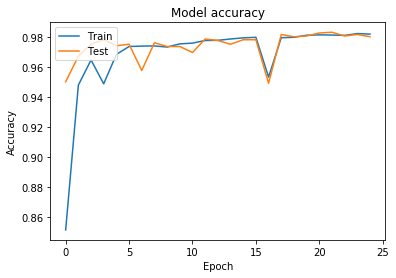

In [10]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [17]:
def predict(domain, maxlen=maxlen):
    """Predict whether a given domain is malicious or benign."""

    domainToken = []
    
    for char in domain:
        domainToken.append(chars_dict[char])
    print(domainToken)

    tokenList = sequence.pad_sequences([domainToken], maxlen)
    
    result = model.predict_classes(tokenList)[0]
    
    if result == 0:
        return "benign"
    else:
        return "malicious"


predict('geeeeeeeeasswedwcwdcxwdcxwsxseee.com')

[36, 29, 29, 29, 29, 29, 29, 29, 29, 10, 9, 9, 4, 29, 21, 4, 11, 4, 21, 11, 1, 4, 21, 11, 1, 4, 9, 1, 9, 29, 29, 29, 32, 11, 35, 24]


'malicious'